In [1]:
from collections import OrderedDict
from itertools import product
import pickle as pkl
import os

import seaborn as sns
import pandas as pd
import numpy as np

from auxiliary import get_propensity_scores_matching_demonstration_4
from auxiliary import get_sample_matching_demonstration_2
from auxiliary import get_sample_matching_demonstration_3
from auxiliary import get_sample_matching_demonstration_4
from auxiliary import get_sparsity_pattern_by_treatment
from auxiliary import get_sparsity_pattern_overall
from auxiliary import get_propensity_score_3
from auxiliary import plot_propensity_score
from auxiliary import get_common_support
from auxiliary import get_lalonde_data
from auxiliary import get_inv_odds
from auxiliary import plot_weights
from auxiliary import get_odds

np.random.seed(123)

# Lecture 5: Matching estimators of causal effects

## Introduction

There exists only one back-door path $D \leftarrow S \leftrightarrow X \rightarrow Y$ and both $S$ nor $X$ are observable. Thus, we have a choice to condition on either one of them.

<img src="material/fig-conditioning-balance-adjust.png" height=300 width=300 />

* $X$, regression estimator, adjustment-for-other-causes conditioning strategy
* $S$, matching estimator, balancing conditioning strategy

**Agenda**

* matching as conditioning via stratification
* matching as weighting
* matching as data analysis algorithm

**Fundamental concepts**

* stratification of data
* weighting to achieve balance
* propensity scores

**Views on matching**

* method to form quasi-experimental contrasts by sampling comparable treatment and control cases
* nonparametric method of adjustment for treatment assignment patterns

**Simulation data**

The simulated data is inspired by real-world applications and thus rather complex. Nevertheless, the will serve as examples for several of the upcoming lectures. That is why we will invest some time initially to set up one of them in details.

## Matching as conditioning via stratification

Individuals within groups determined by $S$ are entirely indistinguishable from each other in all ways except 

* observed treatment status

* differences in potential outcomes that are independent of treatment status

More formally, we are able to assert the following **conditional independence assumptions**.

\begin{align*}
E[Y^1 \mid D = 1, S] = E[Y^1 \mid D = 0, S] \\
E[Y^0 \mid D = 1, S] = E[Y^0 \mid D = 0, S]
\end{align*}

implied by ...

* treatment assignment is ignorable
* selection on observables

**ATC**

\begin{align*}
E[\delta \mid D = 0, S] & = E[Y^1 - Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 0, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

**ATT**
\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

<img src="material/fig-matching-demonstration-1.png" height=500 width=500 />

**Features**

* The gains from treatment participation differ in each stratum and those that have the most to gain are more likely to participate. So unconditional independence between $D$ and $(Y^1, Y^2)$ does not hold.

Let's study these idealized conditions for a simulated dataset.

In [2]:
def get_sample_matching_demonstration_1(num_agents):
    """Simulate sample

    Simulates a sample based for mathcing demonstration one using the information provided
    in Table 6.1.

    Args:
        num_agents: An integer that specifies the number of individuals
            to sample.
       
    Returns:
        Returns a dataframe with the observables (Y, S, D) as well as
        the unobservables (Y_1, Y_0).
    """

    def get_potential_outcomes(s):
        """ Get potential outcomes.
       
        Assigns the potential outcomes based on the observable S and
        the information in Table 6.1.
       
        Notes:
            The two potential outcomes are solely a function of the 
            observable and are not associated with the treatment
            variable D.
       
        Args:
            s: an integer for the value of the stratification variable
           
        Returns:
            A tuple with the two potential outcomes.         
        """
        if s == 1:
            y_1, y_0 = 4, 2
        elif s == 2:
            y_1, y_0 = 8, 6
        elif s == 3:
            y_1, y_0 = 14, 10
        else:
            raise AssertionError

        # We want some randomness.
        y_1 += np.random.normal()
        y_0 += np.random.normal()

        return y_1, y_0

    # Store some information about the sample variables
    # and initialize an empty dataframe.
    info = OrderedDict()
    info["Y"] = np.float
    info["D"] = np.int
    info["S"] = np.int
    info["Y_1"] = np.float
    info["Y_0"] = np.float

    df = pd.DataFrame(columns=info.keys())

    for i in range(num_agents):
        # Simulate from the joint distribution of the
        # observables.
        deviates = list(product(range(1, 4), range(2)))
        probs = [0.36, 0.08, 0.12, 0.12, 0.12, 0.20]
        idx = np.random.choice(range(6), p=probs)
        s, d = deviates[idx]

        # Get potential outcomes and determine observed
        # outcome.
        y_1, y_0 = get_potential_outcomes(s)
        y = d * y_1 + (1 - d) * y_0

        # Collect information
        df.loc[i] = y, d, s, y_1, y_0

    # We want to enforce suitable types for each column.
    # Unfortunately, this cannot be done at the time of
    # initialization.
    df = df.astype(info)

    return df

Let us see our simulation in action.

In [74]:
df = get_sample_matching_demonstration_1(num_agents=1000)
df[["Y", "D", "S"]].head()

,Y,D,S
0,14.581365,1,3
1,13.112430,1,3
2,2.901336,0,1
3,13.754524,1,3
4,4.819434,1,1


We are in the comfortable position to not only compute the naive estimate but also the true average treatment effect.

In [75]:
ate_naive = df.query("D == 1")["Y"].mean() - df.query("D == 0")["Y"].mean()
ate_true = df["Y_1"].sub(df["Y_0"]).mean()

f"The true ATE is {ate_true:4.2f} while its naive estimate is {ate_naive:4.2f}. Why?"

'The true ATE is 2.64 while its naive estimate is 5.96. Why?'

What to do?

In [76]:
df.groupby(["S", "D"])["Y"].mean()

S  D
1  0     2.017118
   1     3.742485
2  0     5.878618
   1     8.172351
3  0     9.931443
   1    13.974348
Name: Y, dtype: float64

Note that the observed outcomes within each stratum correspond to the average potential outcome 
within the stratum. We can compute the average treatment effect by looking at the difference within each strata.

In [77]:
rslt_outc = df.groupby(["S", "D"])["Y"].mean()
rslt_strat = df["S"].value_counts(normalize=True)

ate_est = 0.0
for s in [1, 2, 3]:
    ate_est += (rslt_outc.loc[s, 1] - rslt_outc.loc[s, 0]) * rslt_strat[s]

f"The stratified estimate for the ATE is {ate_est:4.2f}"

'The stratified estimate for the ATE is 2.58'

The ATT and ATC can be computed analogously just by applying the appropriate weights to the strata-specific effect of treatment.

More generally.

\begin{align*}
\{E_N [y_i \mid d_i = 1, s = s_i] - E_N [y_i \mid d_i = 0, s = s_i]\} \\
\xrightarrow{p} E[Y^1 - Y^0\mid S = s] = E[\delta \mid S = s].
\end{align*}
Weighted sums of these stratified estimates can then be taken such as for the unconditional ATE:
\begin{align*}
& \sum_s \{E_N[y_i \mid d_i = 1, s_i = s] - E_N[y_i \mid d_i = 0, s_i = s]\} \\
& * {\Pr}_N[s_i = s] \xrightarrow{p} E[\delta]
\end{align*}


This examples shows all of the basic principles in matching estimators that we will discuss in 
greater detail in this lecture. 

* Treatment and control subjects are matched together in the sense that they are grouped together 
into strata.

* An average difference between the outcomes of the treatment and control subjects is estimated, 
based on a weighting of the strata by common distribution.

### Overlap conditions

In [78]:
df = get_sample_matching_demonstration_2(num_agents=1000)
df[["Y", "D", "S"]].head()

,Y,D,S
0,7.342888,1,2
1,13.859393,1,3
2,6.846383,1,2
3,8.172273,1,2
4,2.136033,0,1


In [79]:
df.groupby(["S", "D"])["Y"].mean()

S  D
1  0     2.043343
2  0     5.928079
   1     8.005814
3  0    10.122801
   1    13.979615
Name: Y, dtype: float64

Can we at least learn about the treatment on the treated? What else can we do?

## Matching as weighting

As indicated by the stylized example, there are often many strata where we do not have treated and control individuals available at the same time.

$\rightarrow$ combine information from different strata with the same propensity score $p$

**Definition** The estimated propensity score is the estimated probability of taking the treatment as a function of variables that predict treatment assignment, i.e. $\Pr[D = 1 \mid S]$.

$\rightarrow$ stratifying on the propensity score itself ameliorates the sparseness problem because the propensity score can be treated as a single stratifying variable (Rosenbaum & Rubin (1983)).

In [80]:
a_grid = np.linspace(0.01, 1.00, 100)
b_grid = np.linspace(0.01, 1.00, 100)

# We need to study some features of this function to
# to get a sense on the underyling economics.
df, counts = get_sample_matching_demonstration_3(a_grid, b_grid)
df.head()

,a,b,d,y,y_1,y_0,p
0,0.01,0.01,0,101.709109,101.087323,101.709109,0.330041
1,0.01,0.01,0,96.491446,90.933327,96.491446,0.330041
2,0.01,0.01,1,99.241464,99.241464,108.273925,0.330041
3,0.01,0.04,0,101.224172,103.692177,101.224172,0.334033
4,0.01,0.04,0,98.396149,103.984479,98.396149,0.334033


**underlying causal graphs**

<img src="material/fig-matching-demonstration-3.png" height=500 width=500 />

We will now look at different ways to construct estimates for the usual causal parameters. So, we first compute their true counterparts.

In [81]:
stat = df["y_1"].sub(df["y_0"]).mean()
print(f"ATE true:  {stat:5.3f}")

stat = df.query("d == 1")["y"].mean() - df.query("d == 0")["y"].mean()
print(f"ATE naive: {stat:5.3f}")

ATE true:  4.506
ATE naive: 4.799


Let's collect all effects in a dictionary for use further downstream.

In [82]:
true_effects = list()
true_effects += [(df["y_1"] - df["y_0"])[(df["d"] == 1)].mean()]
true_effects += [(df["y_1"] - df["y_0"])[(df["d"] == 0)].mean()]
true_effects += [(df["y_1"] - df["y_0"]).mean()]

How about the issue of sparsity on the data?

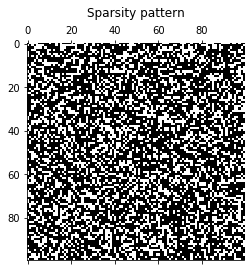

In [60]:
get_sparsity_pattern_overall(counts)

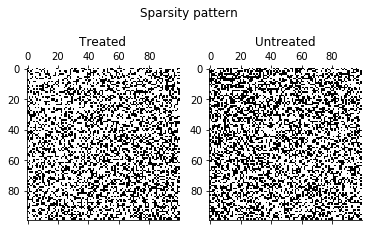

In [61]:
get_sparsity_pattern_by_treatment(counts)

How does the propensity score $P(D = 1\mid S)$ as a function of the observables $(a, b)$ look like?

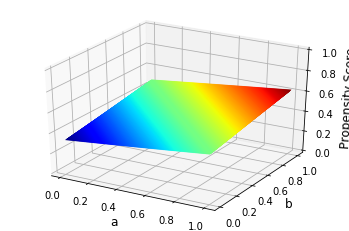

In [62]:
plot_propensity_score(a_grid, b_grid)

We still must be worried about common support.

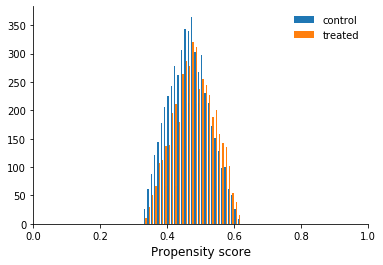

In [63]:
get_common_support(df)


\begin{align*}
\hat{\delta}_{\text{ATT, weight}} \equiv \left( \frac{1}{n^1}\sum_{i:d_i = 1} y_i\right) 
- \left(\frac{\sum_{i:d_i=0}\hat{r}_i y_i}{\sum_{i:d_i = 0} \hat{r}_i}\right)
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, weight}} \equiv 
\left(
\frac{\sum_{i: d_i = 1}\frac{y_i}{\hat{r}_i}}{\sum_{i: d_i = 1}\frac{1}{\hat{r}_i}}
\right)
- \left(\frac{1}{n^0} \sum_{i: d_i = 0} y_i\right) 
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATE, weight}} \equiv \left(\frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATT, weight}} +  \left(1 - \frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATC, weight}}
\end{align*}



**Weights** 

\begin{align*}
r_i = \frac{p_i}{1 - p_i}
\end{align*}

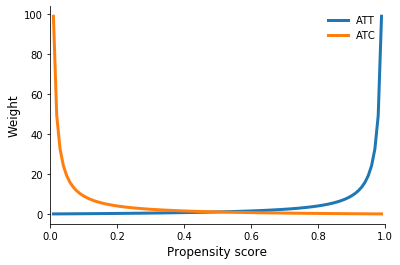

In [44]:
plot_weights()

We will now turn to some programming as it introduces you to the actual setup for the propensity score estimation and points towards the issues of potential model misspecification.

In [67]:
def get_att_weight(df, p):
    """ Get weighted ATT.
    
    Calculates the weighted ATT basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATT.
    """
    weights = get_odds(p)

    is_control = df["d"] == 0
    is_treated = df["d"] == 1

    value, weights = df["y"][is_control], weights[is_control]
    att = df["y"][is_treated].mean() - np.average(value, weights=weights)

    return att


def get_atc_weight(df, p):
    """ Get weighted ATC.
    
    Calculates the weighted ATC basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATC.
    """
    weights = get_inv_odds(p)

    is_control = df["d"] == 0
    is_treated = df["d"] == 1

    value, weights = df["y"][is_treated], weights[is_treated]
    atc = np.average(value, weights=weights) - df["y"][is_control].mean()

    return atc


def get_ate_weight(df, p):
    """ Get weighted ATE.
    
    Calculates the weighted ATE basd on a provided
    dataset and the propensity score.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATE.
    """
    share_treated = df["d"].value_counts(normalize=True)[1]

    atc = get_atc_weight(df, p)
    att = get_att_weight(df, p)

    return share_treated * att + (1.0 - share_treated) * atc


rslt = dict()
for model in ["true", "correct", "misspecified"]:
    
    print("")
    print(model.capitalize())
    
    p = get_propensity_score_3(df, model)

    rslt[model] = list()
    rslt[model] += [get_att_weight(df, p)]
    rslt[model] += [get_atc_weight(df, p)]
    rslt[model] += [get_ate_weight(df, p)]

    print(
        "estimated: ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}".format(*rslt[model])
    )
    print(
        "true:      ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}".format(*true_effects)
    )


True
estimated: ATT 4.738 ATC 4.524 ATE 4.625
true:      ATT 4.549 ATC 4.259 ATE 4.397
Optimization terminated successfully.
         Current function value: 0.684420
         Iterations 4

Correct
estimated: ATT 4.737 ATC 4.530 ATE 4.627
true:      ATT 4.549 ATC 4.259 ATE 4.397
Optimization terminated successfully.
         Current function value: 0.684445
         Iterations 4

Misspecified
estimated: ATT 4.739 ATC 4.526 ATE 4.626
true:      ATT 4.549 ATC 4.259 ATE 4.397


If the treatment assignment can be modeled perfectly, one can solve the sparseness problem that afflict finite datasets. 

**Requirements**

* perfect stratification of the propensity-score-estimating equation
    
    * capture all back-door paths
    * misspecification of propensity score equation

## Matching as data analysis algorithm

\begin{align*}
\hat{\delta}_{\text{ATT, match}} = \frac{1}{n^1} \sum_i \left[
(y_i \mid d_i = 1) - \sum_j \omega_{i, j} (y_j \mid d_j =0 )
\right]
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, match}} = \frac{1}{n^0} \sum_j \left[
 \sum_i \omega_{j, i} (y_i\mid d_i = 1) - (y_j \mid d_j = 0)
\right]
\end{align*}

### Basic variants

* exact matching

    * construct counterfactual based on individuals with identical $S$


* nearest-neighbor and caliper

    * construct counterfactual based on individuals closest on a unidimensional measure (e.g. propensity score), caliper ensures reasonable maximum distance

* interval matching

    * construct counterfactual by sorting individuals into segments based on unidimensional metric


* kernel matching

    * constructs counterfactual based on all individuals but weights them cased on the distance

### Benchmarking tutorial

We revisit a simulated version of the data used in Morgan (2001). He contributes to the debate over the size of the causal of effect of Catholic schooling on test scores. The dataset is provided by the textbook and also available in our online repository.

In [69]:
df = get_sample_matching_demonstration_4()
df.head()

,y,treat,asian,hispanic,black,natamer,urban,neast,ncentral,south,...,ncentralblack,southblack,twohisp,neasthisp,ncentralhisp,southhisp,yt,yc,dshock,d
0,124.820446,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,128.815053,124.820446,-2.189125,3.994607
1,100.389487,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,104.467199,100.389487,-2.517059,4.077712
2,101.244684,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,105.924622,101.244684,-1.307933,4.679938
3,99.257258,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,97.574659,99.257258,-7.004977,-1.682599
4,92.977159,0,0,0,0,0,0.0,1,0,0,...,0,0,0,0,0,0,98.577122,92.977159,-0.236095,5.599963


In [70]:
example_covariates = ["black", "urban", "test"]
df[example_covariates].describe()

,black,urban,test
count,10000.000000,10000.00000,10000.000000
mean,0.096100,0.38910,-0.002229
std,0.294743,0.48757,0.991747
min,0.000000,0.00000,-3.862709
25%,0.000000,0.00000,-0.676463
50%,0.000000,0.00000,-0.006683
75%,0.000000,1.00000,0.660488
max,1.000000,1.00000,3.722783


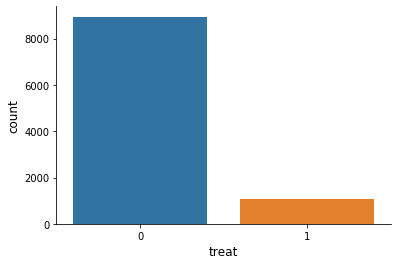

In [71]:
sns.countplot(x="treat", data=df)

<img src="material/fig-catholic-school-example.png" height=500 width=500 />

Is there any hope in identifying the $ATE$?

<img src="material/fig-matching-demonstration-four-propensity-score.png" height=500 width=500 />

<img src="material/fig-matching-demonstration-four-potential-outcome.png" height=500 width=500 />

Here comes the key feature that generates the dependence between $D$ and $Y$ based on an unobservable.

\begin{align*}
y_i^1 = y_i^0 + \delta^\prime_i + \delta^{\prime\prime}_i
\end{align*}

$\rightarrow$ $\delta^{\prime\prime}_i$ is a associated with one of the potential outcomes and also affects the probability to select treatment.

However, we can still identify the $ATT$. Why?

\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

In [72]:
stat = (df["yt"] - df["yc"])[df["treat"] == 1].mean()
print(f"The true ATT is {stat:5.3f}")

The true ATT is 6.957


Optimization terminated successfully.
         Current function value: 0.252643
         Iterations 8


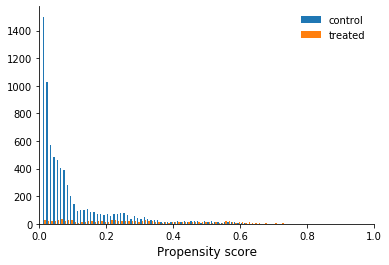

In [22]:
def nearest_neighbor_algorithm_for_att(df, check_store=True):

    if check_store:
        if os.path.exists("matched.ngbr.pkl"):
            return pkl.load(open("matched.ngbr.pkl", "rb"))

    # We select all treated individuals
    df_control = df[df["treat"] == 0]
    df_treated = df[df["treat"] == 1]

    rslt = np.full((df_treated.shape[0], 11), np.nan)

    # We now iterate over all treated individuals and
    # find a set of neighbors.
    for i, (index, row) in enumerate(df_treated.iterrows()):

        y, p, b, u, t = row[["y", "p", "black", "urban", "test"]]
        df_control = df_control.assign(distance=np.abs(df_control["p"] - p))

        idx_ngbr = df_control["distance"].idxmin()
        y_ngbr, p_ngbr = df_control.loc[idx_ngbr, ["y", "p"]]
        b_ngbr, u_ngbr = df_control.loc[idx_ngbr, ["black", "urban"]]
        t_ngbr = df_control.loc[idx_ngbr, ["test"]]

        rslt[i] = [i, y, y_ngbr, p, p_ngbr, b, b_ngbr, u, u_ngbr, t, t_ngbr]

    columns = ["count", "y", "y_ngbr", "p", "p_ngbr", "b", "b_ngbr"]
    columns += ["u", "u_ngbr", "t", "t_ngbr"]
    df = pd.DataFrame(rslt, columns=columns)

    pkl.dump(df, open("matched.ngbr.pkl", "wb"))

    return df


df = get_sample_matching_demonstration_4()
df["p"] = get_propensity_scores_matching_demonstration_4(df)
get_common_support(df, "treat")

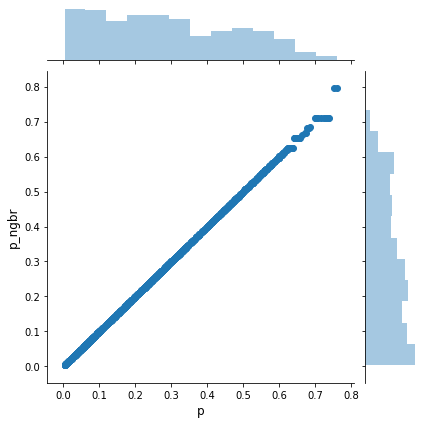

In [23]:
df_matched = nearest_neighbor_algorithm_for_att(df, False)
sns.jointplot("p", "p_ngbr", df_matched)

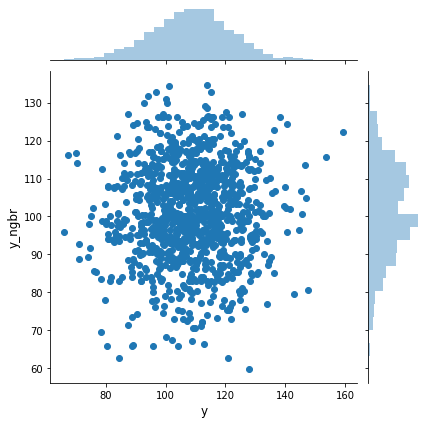

In [24]:
sns.jointplot("y", "y_ngbr", df_matched)

How do our covariantes balance across treatment status?

In [25]:
df.groupby("treat")[example_covariates].mean().T

treat,0,1
black,0.092646,0.125475
urban,0.337953,0.824144
test,-0.039018,0.310690


We now want to revisit the balancing of covariates.

In [26]:
rename = {
    "y_ngbr": "y",
    "p_ngbr": "p",
    "b_ngbr": "b",
    "u_ngbr": "u",
    "t_ngbr": "t",
}

df_control = df_matched[["y_ngbr", "p_ngbr", "b_ngbr", "u_ngbr", "t_ngbr"]]
df_control = df_control.rename(columns=rename)
df_control = df_control.assign(treat=0)

df_treated = df_matched[["y", "p", "b", "u", "t"]]
df_treated = df_treated.assign(treat=1)

df_subset = pd.concat([df_treated, df_control])
df_subset.groupby("treat").mean().T

treat,0,1
y,101.210034,108.445596
p,0.290813,0.290772
b,0.141635,0.125475
u,0.826996,0.824144
t,0.308589,0.310690


Let's take a little detour and look at the balancing of observables in the Lalonde dataset.

In [27]:
df = get_lalonde_data()
df.head()

,data_id,treat,age,education,black,hispanic,married,nodegree,re75,re78,Y,Y_0,Y_1,D
0,Lalonde Sample,1,37,11,1,0,1,1,0.0,9930.0460,9930.0460,NaN,9930.0460,1
1,Lalonde Sample,1,22,9,0,1,0,1,0.0,3595.8940,3595.8940,NaN,3595.8940,1
2,Lalonde Sample,1,30,12,1,0,0,0,0.0,24909.4500,24909.4500,NaN,24909.4500,1
3,Lalonde Sample,1,27,11,1,0,0,1,0.0,7506.1460,7506.1460,NaN,7506.1460,1
4,Lalonde Sample,1,33,8,1,0,0,1,0.0,289.7899,289.7899,NaN,289.7899,1


In [28]:
example_covariates = ["black", "married", "hispanic", "re75"]
df.groupby("treat")[example_covariates].mean().T

treat,0,1
black,0.800000,0.801347
married,0.157647,0.168350
hispanic,0.112941,0.094276
re75,3026.682743,3066.098187


The covariates are balanced before any reweighting thanks to the assignment mechanisms.



Which matching algorihtm is the best?

**Incomplete specification**

* missing higher-order interactions in propensity score and omission of cognitive variable

<img src="material/fig-matching-demonstration-four-benchmarking.png" height=500 width=500 />

## Resources

* Heckman, James J., Hidehiko Ichimura, and Petra Todd. 1997. “Matching as an
Econometric Evaluation Estimator: Evidence from Evaluating a Job Training Pro-
gramme.” Review of Economic Studies 64:605–54.

* Heckman, James J. and V. Joseph Hotz. 1989. “Choosing among Alternative Non-
experimental Methods for Estimating the Impact of Social Programs: The Case of
Manpower Training.” Journal of the American Statistical Association 84:862–74.


* Heckman, James J., Hidehiko Ichimura, Jeffrey A. Smith, and Petra Todd. 1998.
“Characterizing Selection Bias Using Experimental Data.” Econometrica 66:
1017–98.

* 1998. “Matching as an Econometric Evaluation Estimator.” Review of Economic
Studies 65:261–94.

* Smith, Jeffery A. and Petra Todd. 2005. “Does Matching Overcome Lalonde’s Critique
of Nonexperimental Estimators?” Journal of Econometrics 125:305–53.

* https://ideas.repec.org/a/tpr/restat/v86y2004i1p30-57.html

* Rosenbaum Rubin 1983

* Morgan 2001